In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
import sys
sys.path.append('../')
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig, read_pickle, augment_data
from colorml.descriptornames import * 
from colorml.kl_anneal import monotonical_kl_anneal
from functools import partial

from sklearn.gaussian_process import GaussianProcessRegressor
import probflow as pf
from probflow.callbacks import MonitorELBO, MonitorMetric, EarlyStopping, KLWeightScheduler

RESULTS = os.path.join('..', 'results', 'baselines')
MODELS = os.path.join('..', 'models', 'baselines')
from numpy.random import seed
seed(821996)

CHEMICAL_FEATURES = metalcenter_descriptors + functionalgroup_descriptors + linker_descriptors + mol_desc  + summed_linker_descriptors + summed_metalcenter_descriptors + summed_functionalgroup_descriptors

Using TensorFlow backend.


In [6]:
import tensorflow_addons as tfa
 
class DenseNetwork2(pf.Module):

    def __init__(self, dims, activation=tf.keras.activations.relu):
        Nl = len(dims)-1 #number of layers
        self.layers = [pf.modules.Dense(dims[i], dims[i+1]) for i in range(Nl)]
        self.activations = (Nl-1)*[activation] + [mapping_to_target_range]

    def __call__(self, x):
        for i in range(len(self.activations)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        return x

In [7]:
import tensorflow_addons as tfa
 
class DenseNetwork(pf.Module):

    def __init__(self, dims, activation=tf.keras.activations.relu):
        Nl = len(dims)-1 #number of layers
        self.layers = [pf.modules.Dense(dims[i], dims[i+1]) for i in range(Nl)]
        self.activations = (Nl-1)*[activation] + [lambda x: x]

    def __call__(self, x):
        for i in range(len(self.activations)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        return x

In [2]:
CHEMICAL_FEATURES = metalcenter_descriptors + functionalgroup_descriptors + linker_descriptors + mol_desc

In [ ]:
df_subset_merged = pd.read_csv('../data/color_feat_merged.csv')

In [ ]:
augment_dict = read_pickle('../data/augment_dict.pkl')

In [ ]:
df_train, df_test = train_test_split(df_subset_merged, train_size=0.7)

In [ ]:
df_train = augment_data(df_train, augment_dict)

In [ ]:
X_train = df_train[CHEMICAL_FEATURES]
y_train = df_train[['r', 'g', 'b']]

X_test = df_test[CHEMICAL_FEATURES]
y_test = df_test[['r', 'g', 'b']]

In [ ]:
name_train = df_train['color_cleaned']
name_test = df_test['color_cleaned']

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_test, X_valid, y_test, y_valid, names_valid, names_valid = train_test_split(X_test, y_test, name_test, train_size=0.9)

In [ ]:
y_train = y_train / 255
y_valid = y_valid / 255
y_test = y_test / 255

In [ ]:
class DensityNetwork(pf.ContinuousModel):

    def __init__(self, units, head_units):
        self.core = DenseNetwork(units)
        self.mean = DenseNetwork2(head_units)
        self.std  = DenseNetwork2(head_units)
        self.batch_norm = pf.modules.BatchNormalization([units[-1]])
        
    def __call__(self, x):
        x = self.core(x)
        x = self.batch_norm(x)
        return pf.Cauchy(self.mean(x), tf.exp(self.std(x)))

# Create the model
model = DensityNetwork([X_train.shape[1], 32, 16], [16, 8, 3])

monitor_mae = MonitorMetric('mae', X_valid, y_valid, verbose=True)
monitor_elbo = MonitorELBO()
early_stopping = EarlyStopping(lambda: monitor_mae.current_metric, patience=30)

kl_annealer = KLWeightScheduler(
                    partial(monotonical_kl_anneal, M=50)
                )


# Fit it!
model.fit(X_train, y_train, callbacks=[monitor_mae, monitor_elbo, early_stopping], batch_size=50, epochs=500, lr=3e-3)

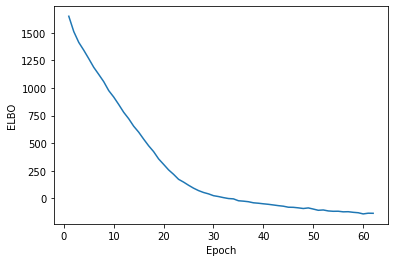

In [40]:
monitor_elbo.plot()

../colorml/utils.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


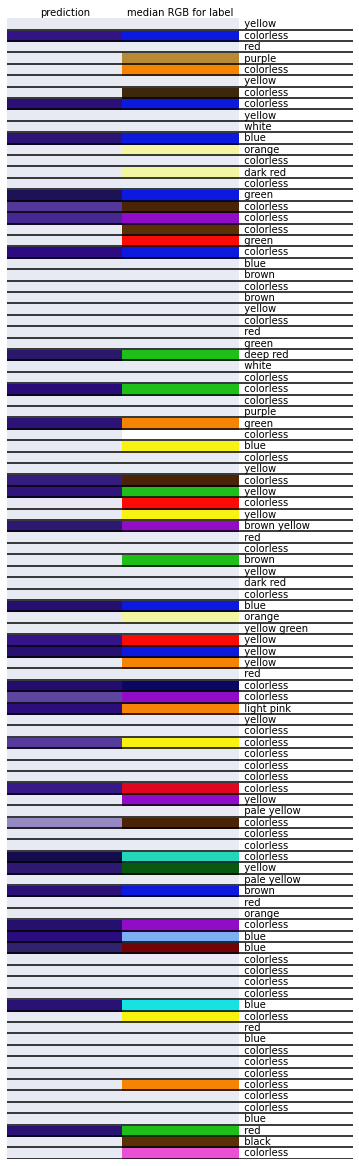

In [41]:
predictions = model.predict(X_train)

plot_predictions(predictions * 255, y_train.values * 255,  name_train.values,  sample=100)

## Trying to use dropout as a measure of uncertainity

https://stackoverflow.com/questions/43529931/how-to-calculate-prediction-uncertainty-using-keras

https://www.reddit.com/r/MachineLearning/comments/7bm4b2/d_what_is_the_current_state_of_dropout_as/

In [36]:
import tensorflow as tf
from keras.layers import Dropout, Dense, BatchNormalization, GaussianDropout, GaussianNoise, LeakyReLU
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from livelossplot.keras import PlotLossesCallback
from keras.constraints import MinMaxNorm
from keras.initializers import Constant
from keras.optimizers import Adam
from colorml.utils import mapping_to_target_range, read_pickle, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig
from livelossplot.keras import PlotLossesCallback

In [ ]:
timestamp = get_timestamp_string()
mlp = Sequential()
mlp.add(Dense(64, activation="relu", 
              kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
mlp.add(Dropout(0.2))
mlp.add(Dense(32,  activation="relu", 
             kernel_initializer='he_normal'))  
mlp.add(Dropout(0.2))
mlp.add(Dense(16,  activation="relu", 
             kernel_initializer='he_normal'))  
mlp.add(Dropout(0.2))
mlp.add(Dense(8,  activation='relu', 
             kernel_initializer='he_normal'))
mlp.add(Dropout(0.2))
mlp.add(Dense(3, activation=mapping_to_target_range, kernel_initializer='he_normal'))


In [364]:
mlp.compile(optimizer=Adam(learning_rate=4e-3), loss=huber_fn, metrics=['mae', 'mean_absolute_percentage_error'])

In [43]:
es = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=20, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

TypeError: __init__() got an unexpected keyword argument 'monitor'

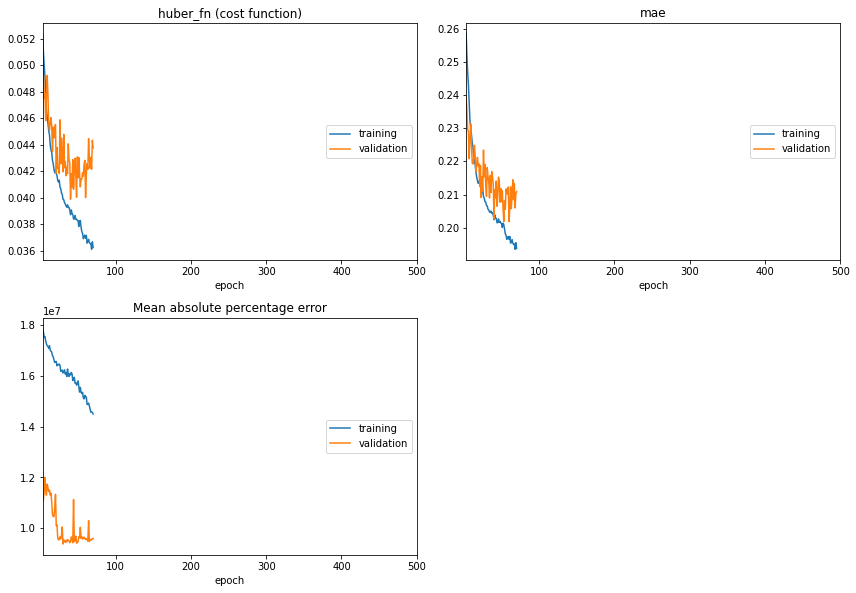

In [366]:
mlp.fit(X_train, y_train, epochs=500, batch_size=264, callbacks=[es, PlotLossesCallback(plot_extrema=False)], validation_data=(X_valid, y_valid))

In [ ]:
import keras.backend as K
f = K.function([mlp.layers[0].input, K.learning_phase()],
               [mlp.layers[-1].output])

In [368]:
def predict_with_uncertainty(f, x, n_iter=1000):
    result = []

    for i in range(n_iter):
        result.append(f([x, 1]))

    result = np.array(result)

    prediction = np.median(result, axis=0)
    uncertainty = result.var(axis=0)
    return result, prediction, uncertainty

In [388]:
result, rediction, uncertainity = predict_with_uncertainty(f, X_test[:100])

In [376]:
def rgb_to_hex_round(c): 
    return rgb_to_hex((int(c[0]), int(c[1]), int(c[2])))

In [386]:
from webcolors import rgb_to_hex

def plot_prediction_dist(predictions_dist, label_names, label_dict, sample=100, outname=None, centrality='median', n_samples=80, width=0.01, figsize=(8,16)):
    """Plot figure that compares color of predictions versus acutal colors.
    
    Arguments:
        predictions {iterable} -- iterable of rgb colors
        labels {iterable} -- iterable of rgb colors
    
    Keyword Arguments:
        sample {int} -- how many samples to plot (default: {100})
        outname {string} -- path to which figure is saved (default: {None})
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    predictions = predictions_dist[:, 0, :sample]
    label_names = label_names.values[:sample]
    label_names_set = set(label_names)
    
   
        
    if centrality == 'median': 
        prediction_centrality = np.median(predictions, axis=0)
        label_centrality_dict = {}
        for color in label_names_set: 
            label_centrality_dict[color] = np.median(label_dict[color], axis=0)

    for i in range(len(label_names)):
        colorname = label_names[i]
        r1 = mpatch.Rectangle((0, i), 1, 1, color=rgb_to_hex_round(prediction_centrality[i]))
        r2 = mpatch.Rectangle((1, i), 1, 1, color=rgb_to_hex_round(label_centrality_dict[colorname]))

        ax.add_patch(r1)
        ax.add_patch(r2)
        
        for j in range(n_samples):
            choice = np.random.randint(0,len(predictions_dist))
            choice2 = np.random.randint(0, len(label_dict[colorname]))
            r3 = mpatch.Rectangle((-0.5 - width * j, i), 0.5, 1, color=rgb_to_hex_round(
                predictions[choice][i]
            ))
            r4 = mpatch.Rectangle((2 + width * j, i), 0.5, 1, color=rgb_to_hex_round(
               label_dict[colorname][choice2]
            ))
            ax.add_patch(r3)
            ax.add_patch(r4)
        
        ax.axhline(i, color="k")

    ax.text(0.5, i + 1.5, "prediction {}".format(centrality), ha="center", va="center", weight='bold')
    ax.text(1.5, i + 1.5, "label {}".format(centrality), ha="center", va="center", weight='bold')
    
    ax.text(0.5 - n_samples * 5.5/6 * width, i + 1.5, "prediction samples", ha="center", va="center", weight='bold')
    ax.text(1.5 + n_samples * 5.5/6 * width, i + 1.5, "colorjeopardy samples", ha="center", va="center", weight='bold')
    
    ax.set_xlim(0 - n_samples * width, 2 + n_samples * width)
    ax.set_ylim(0, i + 2)
    ax.axis("off")

    fig.tight_layout()

    if outname is not None:
        fig.savefig(outname, bbox_inches="tight")


/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


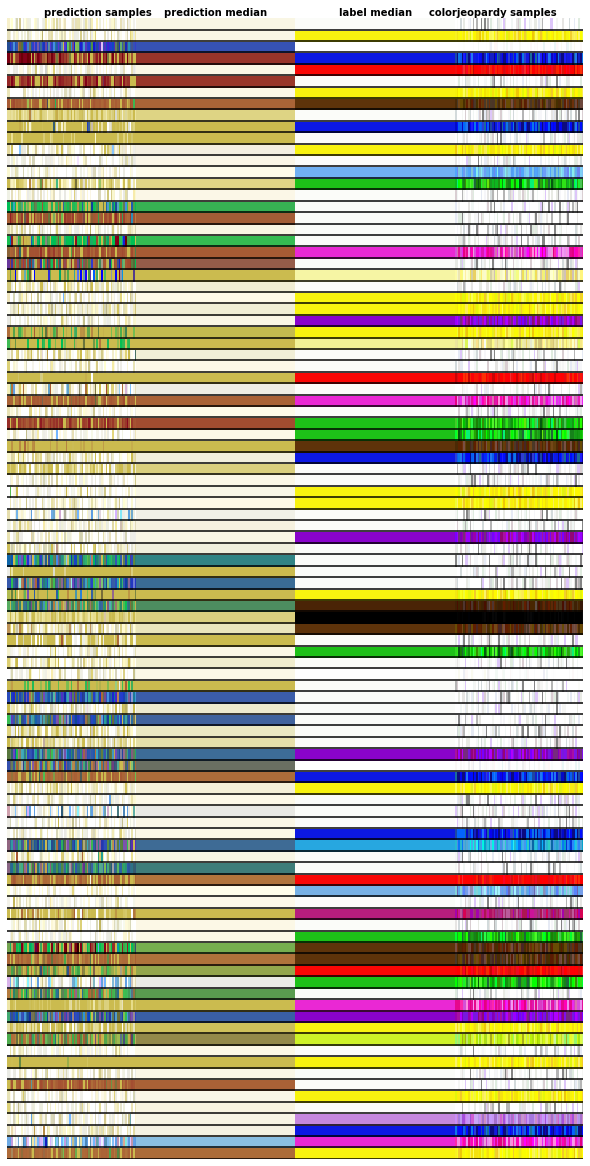

In [389]:
plot_prediction_dist(result * 255, name_test, augment_dict)

### Now, let's try to also model aleoteric uncertainity

In [50]:
from keras.utils import plot_model
from keras.layers import Input, Activation, Dense, Dropout, Concatenate
from keras.regularizers import l2, l1
from keras.models import Model
from keras.optimizers import Adam, RMSprop
import keras.backend as K
from keras.initializers import Constant
from keras.losses import mse

l1rate = 3e-5
dropout_p = 0.25

layers = [32, 32, [16]]

In [51]:
inputlayer = Input(shape=(X_train.shape[1],))

x = inputlayer

for layer in layers[:-2]: 
    x = Dense(layer, activation='linear', activity_regularizer=l1(l1rate), kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_p)(x)

r = x
g = x
b = x

for layer in layers[-1]:
    r = Dense(layer, activation='linear', activity_regularizer=l1(l1rate), kernel_initializer='he_normal')(r)
    r = Activation('relu')(r)
    r = Dropout(dropout_p)(r)

    g = Dense(layer, activation='linear', activity_regularizer=l1(l1rate), kernel_initializer='he_normal')(g)
    g = Activation('relu')(g)
    g = Dropout(dropout_p)(g)

    b = Dense(layer, activation='linear', activity_regularizer=l1(l1rate), kernel_initializer='he_normal')(b)
    b = Activation('relu')(b)
    b = Dropout(dropout_p)(b)


r_mu = Dense(1, activation=mapping_to_target_range, kernel_initializer='he_normal')(r)
r_sigma = Dense(1,  activation='linear', kernel_initializer='he_normal')(r)

g_mu = Dense(1, activation=mapping_to_target_range, kernel_initializer='he_normal')(g)
g_sigma = Dense(1, activation='linear',kernel_initializer='he_normal')(g)

b_mu = Dense(1, activation=mapping_to_target_range, kernel_initializer='he_normal')(b)
b_sigma = Dense(1,  activation='linear', kernel_initializer='he_normal')(b)

output = Concatenate()([r_mu, g_mu, b_mu, r_sigma, g_sigma, b_sigma])
model = Model(inputs=inputlayer, outputs=output)

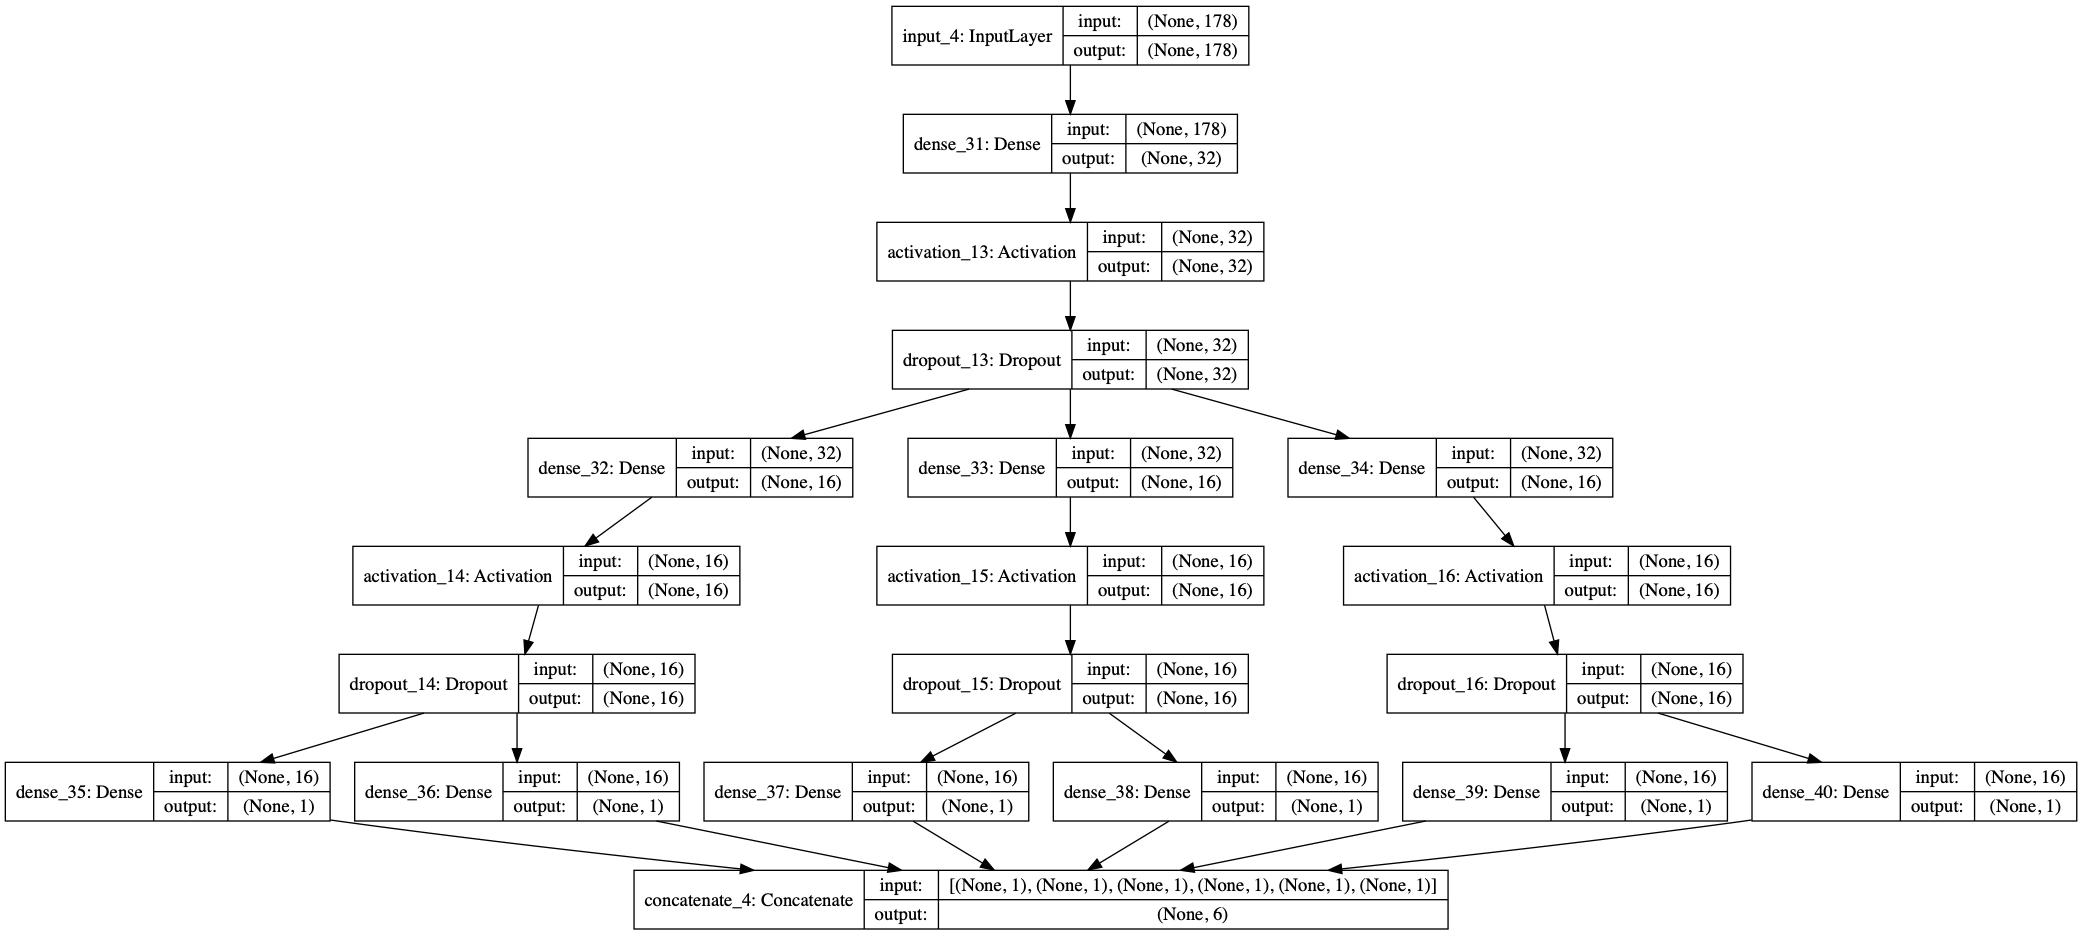

In [52]:
plot_model(model, show_shapes=True)

In [53]:
def empty_y(y): 
    y_fill = np.zeros((len(y), 6))
    y_fill[:,:3] = y
    return y_fill

In [54]:
def heteroscedastic_aleatoric_loss(y_true, y_pred):
    """Multi-Task Learning Using Uncertainty to Weigh Losses
for Scene Geometry and Semantics Kendall, Gal, Cipolla """
    y_log_var = y_pred[:,3:]
    y_pred = y_pred[:,:3]
    y_true = y_true[:,:3]
    
    loss = 0.5 * tf.square(y_true - y_pred) * tf.exp(-y_log_var) + 0.5 * y_log_var
    return tf.reduce_mean(loss)
    

In [55]:
model.compile(optimizer=Adam(), loss=heteroscedastic_aleatoric_loss, metrics=['mae', 'mean_absolute_percentage_error'])

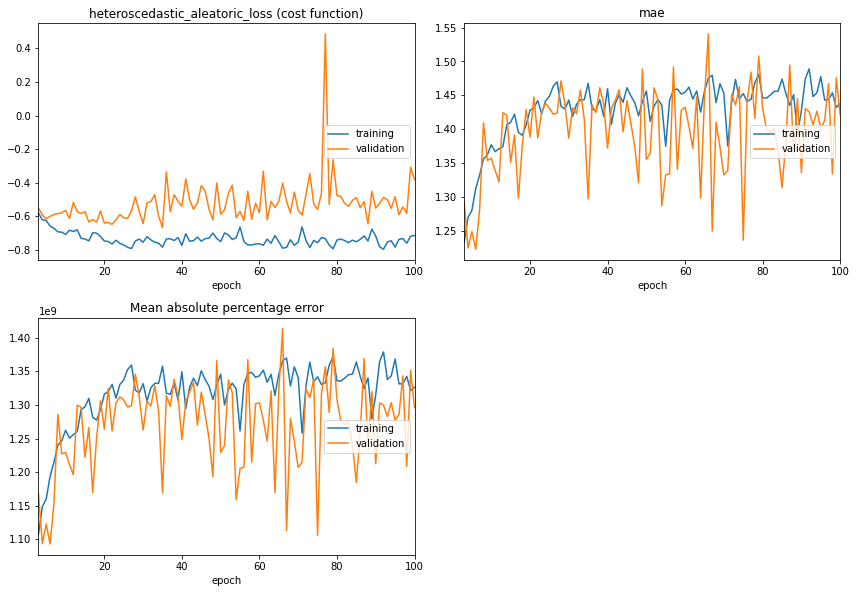

In [56]:
model.fit(X_train, empty_y(y_train), epochs=100, batch_size=264, callbacks=[PlotLossesCallback(plot_extrema=False)], validation_data=(X_valid, empty_y(y_valid)), verbose=1)

In [ ]:
from colorml.utils import predict_with_uncertainty, plot_prediction_dist

In [19]:
def predict_with_uncertainty(
    mlp, x: np.array, n_iter: int = 1000, centrality: str = "mean"
):
    """Use dropout sampling
    
    Args:
        mlp ([type]): keras model
        x (np.array): feature matrix
        n_iter (int, optional): Number of samples from the predictive distribution. 
            Defaults to 1000.
        centrality (str, optional): Method used to calculate the center of the predictive distribution. 
            Defaults to "median".
    
    Returns:
        Union[np.array, np.array, np.array]: All samples from the predictive distribution, centrality measures, variancesƒ
    """
    result = []

    f = K.function([mlp.layers[0].input, K.learning_phase()], [mlp.layers[-1].output[:,:3]])

    for i in range(n_iter):
        result.append(f([x, 1]))

    result = np.array(result)

    if centrality == "median":
        prediction = np.median(result, axis=0)
    elif centrality == "mean":
        prediction = np.mean(result, axis=0)
    uncertainty = result.var(axis=0)
    return result, prediction, uncertainty


In [22]:
from colorml.utils import plot_prediction_dist

In [26]:
result, rediction, uncertainity = predict_with_uncertainty(model, X_train[:20])

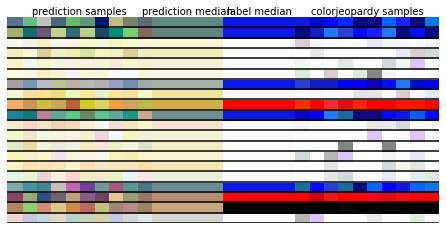

In [27]:
plot_prediction_dist(result * 255, name_train, augment_dict, 20, figsize=(6,3))

In [28]:
model.predict(X_train[:10])

array([[ 0.8461751 ,  0.84162354,  0.82492954, -3.0838997 , -2.604795  ,
        -2.3554463 ],
       [ 0.7885962 ,  0.6621576 ,  0.49523848, -1.9021896 , -1.7993295 ,
        -2.0642295 ],
       [ 0.7066554 ,  0.544801  ,  0.45387787, -1.791804  , -1.7308185 ,
        -2.0879974 ],
       [ 0.4321436 ,  0.5503098 ,  0.58268166, -1.8822583 , -1.7443085 ,
        -2.3712387 ],
       [ 0.929269  ,  0.9416287 ,  0.8641711 , -2.8108697 , -3.027665  ,
        -2.3593402 ],
       [ 0.96614695,  0.9048102 ,  0.71487457, -4.0957785 , -2.8800082 ,
        -2.0170345 ],
       [ 0.9763412 ,  0.9501203 ,  0.85064507, -4.8663177 , -4.0813055 ,
        -2.3535511 ],
       [ 0.9453287 ,  0.9254494 ,  0.78716433, -3.5430267 , -2.853369  ,
        -2.19873   ],
       [ 0.95829785,  0.957844  ,  0.85899085, -4.1401367 , -4.2524166 ,
        -2.3885999 ],
       [ 0.96877277,  0.89714   ,  0.834737  , -4.284686  , -2.866385  ,
        -2.3219147 ]], dtype=float32)

In [866]:
np.exp(-3.517487)

0.02967391208952642